<a href="https://colab.research.google.com/github/amazingvince/Forward-Forward/blob/main/ffa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

epoch 0
Idx 0: g1: 1.739E-03, g2: 2.910E-03, g3: 2.916E-03, g4: 2.920E-03, f1: 6.664E+02, f2: 6.672E+02, f3: 6.665E+02, f4: 6.670E+02
Idx 50: g1: 6.853E-01, g2: 2.905E-03, g3: 2.876E-03, g4: 2.881E-03, f1: 9.412E+02, f2: 6.672E+02, f3: 6.665E+02, f4: 6.670E+02
Idx 100: g1: 5.734E-01, g2: 3.155E-03, g3: 3.248E-03, g4: 3.141E-03, f1: 1.532E+03, f2: 6.674E+02, f3: 6.666E+02, f4: 6.671E+02
epoch 1
Idx 0: g1: 1.267E-01, g2: 2.637E-03, g3: 2.955E-03, g4: 3.192E-03, f1: 1.886E+03, f2: 6.675E+02, f3: 6.668E+02, f4: 6.671E+02
Idx 50: g1: 4.803E-01, g2: 5.494E-03, g3: 1.393E-02, g4: 4.754E-03, f1: 3.266E+03, f2: 6.708E+02, f3: 6.687E+02, f4: 6.676E+02
Idx 100: g1: 7.390E-01, g2: 1.796E-01, g3: 4.349E-01, g4: 5.904E-03, f1: 5.313E+03, f2: 1.006E+03, f3: 7.096E+02, f4: 6.685E+02
epoch 2
Idx 0: g1: 8.401E-01, g2: 6.649E-01, g3: 5.536E-01, g4: 1.215E-02, f1: 6.211E+03, f2: 1.296E+03, f3: 8.017E+02, f4: 6.696E+02
Idx 50: g1: 9.414E-01, g2: 9.722E-01, g3: 1.888E-01, g4: 5.118E-01, f1: 9.299E+03, f2: 2

KeyboardInterrupt: ignored

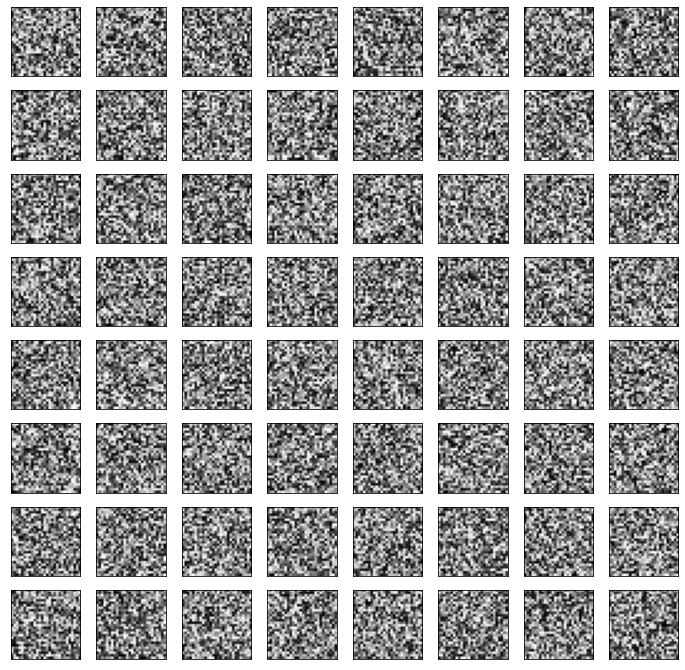

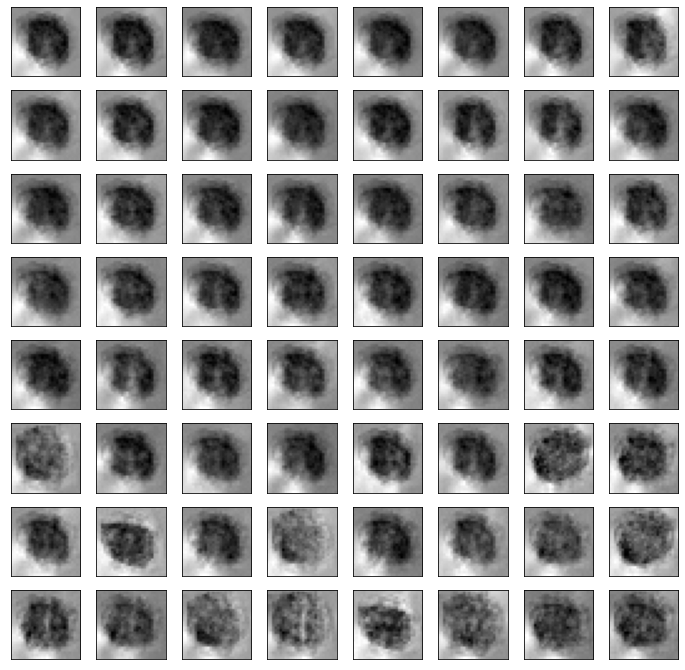

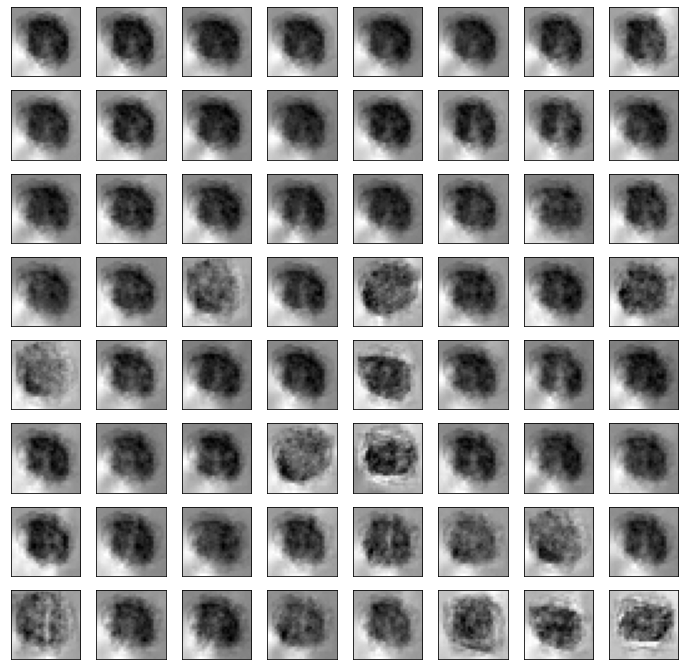

In [38]:
from torch.utils.data import Dataset
from torchvision.transforms.functional import invert
from torchvision.transforms import RandomRotation
import torch.nn.functional as nnf
import torch
import torchvision
import torchvision.utils as vutils

from torch.nn.utils import clip_grad_norm_

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline


def p():
    lin_dict = m1.layer1.weight.data.detach().cpu().numpy()
    dict_fnorm = np.argsort((lin_dict**2).sum(axis=-1))[::-1]
    lin_dict = lin_dict[dict_fnorm][:64].reshape(64, 28, 28)
    lin_dict.shape
    fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(12,12))
    for i in range(8):
      for j in range(8):
        ax[i, j].imshow(lin_dict[i*8 + j], cmap='gray')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

class FFLayer(nn.Module):
    def __init__(self, in_shape, out_shape, bias, wd=5e-2):
        super(FFLayer, self).__init__()
        self.layer1 = nn.Linear(in_shape, out_shape)
        self.bias = bias
        self.wd = wd
       

    def forward(self, x, is_neg):
        y = F.silu(self.layer1(x))
        # print(y.shape)
        goodness = torch.sigmoid((y**2).sum(dim=-1) - self.bias).mean()
        if is_neg:
            self.eta = 5e-1
            (goodness).backward()
        else:
            self.eta = 1e-1
            (-goodness).backward()
        # clip_grad_norm_(self.layer1.weight.grad, 1)
        # clip_grad_norm_(self.layer1.bias.grad, 1)

        self.layer1.weight.data = self.layer1.weight.data - self.eta * self.layer1.weight.grad
        self.layer1.weight.data *= (1-self.wd)
        self.layer1.bias.data = self.layer1.bias.data - self.eta * self.layer1.bias.grad
        self.layer1.bias.data *= (1-self.wd)

        y_norm = y / torch.linalg.norm(y, dim=-1).unsqueeze(-1)

        return (y_norm.detach(), 
                goodness.detach().cpu().item(), 
                (self.layer1.weight.data.detach().cpu()**2).sum().item())
        
    def predict(self, x):
        y = F.silu(self.layer1(x))

        return  (y / torch.linalg.norm(y, dim=-1).unsqueeze(-1)).detach()




class ShufflePatches(object):
  def __init__(self, patch_size):
    self.ps = patch_size

  def __call__(self, x):
    # divide the batch of images into non-overlapping patches
    u = nnf.unfold(x, kernel_size=self.ps, stride=self.ps, padding=0)
    # permute the patches of each image in the batch
    pu = torch.cat([b_[:, torch.randperm(b_.shape[-1])][None,...] for b_ in u], dim=0)
    # fold the permuted patches back together
    f = nnf.fold(pu, x.shape[-2:], kernel_size=self.ps, stride=self.ps, padding=0)
    return f
shuffle_patches = ShufflePatches(4)

neg_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0)

])


mnist_data = torchvision.datasets.MNIST('datasets', download=True, train=True, transform=torchvision.transforms.transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=512, shuffle=True, num_workers=1)


m1 = FFLayer(784, 2000, 20, 0.0001).to("cuda") #0.0001
m2 = FFLayer(2000, 2000, 6, 0.0001).to("cuda")
m3 = FFLayer(2000, 2000, 6, 0.0001).to("cuda")
m4 = FFLayer(2000, 2000, 6, 0.0001).to("cuda")

g_list = {'g1': [], 'g2': [], 'g3': [], 'g4': []}
f_list = {'f1': [], 'f2': [], 'f3': [], 'f4' : []}

g_list_p = {'g1': [], 'g2': [], 'g3': [], 'g4': []}
f_list_p = {'f1': [], 'f2': [], 'f3': [], 'f4' : []}

g_list_n = {'g1': [], 'g2': [], 'g3': [], 'g4': []}
f_list_n = {'f1': [], 'f2': [], 'f3': [], 'f4' : []}

for e in range(50):
  print(f"epoch {e}")
  if e % 5 == 0:
      p()
  for batch_idx, (data, label) in enumerate(data_loader):
      if batch_idx % 2 == 0:
          data = shuffle_patches(data)
          data = neg_transform(data)
        # vutils.save_image(data, f"{batch_idx}_test.png", normalize=False)
      else:
          data = padded_imgs =  transforms.RandomResizedCrop((28,28), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333))(data)
          # vutils.save_image(data, f"{batch_idx}_test_2.png", normalize=False)


      
      x1, g1, f1 = m1.forward(data.reshape(-1,784).to("cuda"), batch_idx % 2 == 0)
      x2, g2, f2 = m2.forward(x1, batch_idx % 2 == 0)
      x3, g3, f3 = m3.forward(x2, batch_idx % 2 == 0)
      out, g4, f4 = m4.forward(x3, batch_idx % 2 == 0)

      if batch_idx%2 == 0:
          g_list_n['g1'].append(g1)
          g_list_n['g2'].append(g2)
          g_list_n['g3'].append(g3)
          g_list_n['g4'].append(g4)
          f_list_n['f1'].append(f1)
          f_list_n['f2'].append(f2)
          f_list_n['f3'].append(f3)
          f_list_n['f4'].append(f4)
      else:
          g_list_p['g1'].append(g1)
          g_list_p['g2'].append(g2)
          g_list_p['g3'].append(g3)
          g_list_p['g4'].append(g4)
          f_list_p['f1'].append(f1)
          f_list_p['f2'].append(f2)
          f_list_p['f3'].append(f3)
          f_list_p['f4'].append(f4)


      if batch_idx%50 == 0:
          g_list['g1'].append(g1)
          g_list['g2'].append(g2)
          g_list['g3'].append(g3)
          g_list['g4'].append(g4)
          f_list['f1'].append(f1)
          f_list['f2'].append(f2)
          f_list['f3'].append(f3)
          f_list['f4'].append(f4)
          print(f"Idx {batch_idx}: g1: {g1:.3E}, g2: {g2:.3E}, g3: {g3:.3E}, g4: {g4:.3E}, f1: {f1:.3E}, f2: {f2:.3E}, f3: {f3:.3E}, f4: {f4:.3E}")



In [ ]:
p()

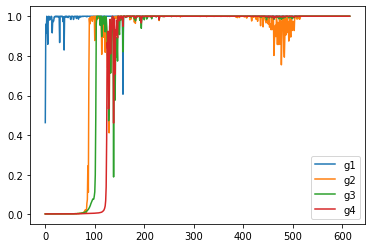

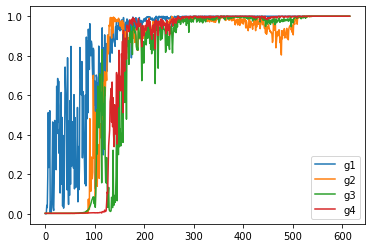

In [39]:
plt.figure()
for key, data_list in g_list_p.items():
    plt.plot(data_list, label=key)
plt.legend()

plt.figure()
for key, data_list in g_list_n.items():
    plt.plot(data_list, label=key)
plt.legend()

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable


mnist_data = torchvision.datasets.MNIST('datasets', download=True, train=True, transform=torchvision.transforms.transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=256, shuffle=True, num_workers=1)

model = torch.nn.Linear(2000, 10)
model.to("cuda")



loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

for e in range(50):
  print(f"epoch {e}")
  for batch_idx, (data, label) in enumerate(data_loader):
    x1 = m1.predict(data.reshape(-1,784).to("cuda"))
    x2 = m2.predict(x1)
    x3 = m3.predict(x2)
    i = m4.predict(x3)
    # forward
    out = model(i.to("cuda"))
    loss = loss_function(out, label.to("cuda"))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # show
  if e % 10 == 0:
    print('Epoch[{}], loss: {:.6f}'
          .format(e, loss.data.item()))

# # predicting
# print(model(torch.tensor([[500, 500, 500]], dtype=torch.float32)))

In [23]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            x1 = m1.predict(data.reshape(-1,784).to("cuda"))
            x2 = m2.predict(x1)
            x3 = m3.predict(x2)
            i = m4.predict(x3)




            output = model(i)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



mnist_data = torchvision.datasets.MNIST('datasets', download=True, train=False, transform=torchvision.transforms.transforms.ToTensor())
data_loader_test = torch.utils.data.DataLoader(mnist_data, batch_size=256, shuffle=True, num_workers=1)

test(model, "cuda", data_loader_test)


Test set: Average loss: -0.3294, Accuracy: 2194/10000 (22%)

